# Simple topology optimization for a bookshelf
ToDo: Copy example

The boundary value problem for the linear elastic model reads as follows:

- momentum balance 
- dirichlet 
- Neumann

## Numerical parameters 
First, lets define some numerical parameters for the problem. 
- The parameter 'f' is the applied load per lenght at the top of the bookshelf. 
- The parameter 'p' is the order parameter in the SIMP approach.
- The parameter 'refinements' defines, how often the square domain should be subdivided into smaller elements. A value of 0 results in a single element and a value of 1 results in four elements, because the square is subdivided in two parts in each direction x and y. A value of 2 results in 16 elements, 3 in 81 and so on...
- The parameter 'vol_constraint' sets the desired volume of the optimized part.

In [1]:
f = 10.0
p = 3
refinements = 4
vol_constraint = 0.5

## Material model 

A material model is required to compute the stress for a given strain field $\varepsilon = \textrm{symgrad}(\bm{u})$. An isotropic material model is used here, which is defined by two parameters, e.g. Youngs modulus and poisson ratio or the two Lame constants. The 3D notation is a bit simpler for Lame constants $\mu$ and $\lambda$, hence this version is chosen here. It reads 

$\bm{\sigma} = 2 \mu \bm{\varepsilon} + \lambda \textrm{tr}(\bm{\varepsilon}) \bm{I}$, 

were the SIMP approach is applied to compute 

$ \mu = \mu_0 \hat{\rho}^p$ and $\lambda = \lambda \hat{\rho}^p$

with the normalized density 

$\hat{\rho} = \frac{\rho}{\rho_0}$.

In [2]:
def stress(eps, rho_hat):
    from skfem.helpers import trace, eye
    mu = 1.0 * rho_hat**p 
    lbd = 1.0 * rho_hat**p 
    return 2.0 * mu * eps + lbd * eye(trace(eps), eps.shape[0])

## Weak form of the momentum equation



The weak form of the momentum balance is 

$\int_\Omega \bm{\sigma}(\bm{\varepsilon}) \cdot \textrm{symgrad}(\bm{v}) dV = f \int_{\partial \Omega} \bm{v} \cdot \bm{n} dA$

In [3]:
import skfem as fem

@fem.BilinearForm
def momentum_flux(u, v, w):
    from skfem.helpers import ddot, sym_grad
    return ddot(stress(sym_grad(u), w.rho), sym_grad(v))

@fem.LinearForm
def loading(v, w):
    from skfem.helpers import dot
    return dot(w.n, v)

## Finite element mesh 
Create a finite element mesh with quadratic isoparametric elements.

In [4]:
mesh = fem.MeshQuad().refined(refinements)

e1 = fem.ElementQuad1()
mapping = fem.MappingIsoparametric(mesh, e1)
e = fem.ElementVector(e1)
basis = fem.Basis(mesh, e, mapping)
basis0 = basis.with_element(fem.ElementQuad0())

## Boundary conditions

In [5]:
load_basis = fem.FacetBasis(mesh, e, facets=mesh.boundaries["top"])

dofs = {'left' : basis.get_dofs(lambda x: x[0] == 0.0)}
u0 = basis.zeros()
I = basis.complement_dofs(dofs)

## Target function for topology optimization

In [6]:
def target_function(design):
    # Assembly
    K = fem.asm(momentum_flux, basis, rho=basis0.interpolate(design))
    B = f  * fem.asm(loading, load_basis)

    # Solution
    u = fem.solve(*fem.condense(K, B, x=u0, I=I))
    
    # Evaluation of strain energy
    return 0.5 * (u @ K @ u)

## Optimization

/Users/nilsmeyer/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Success state:True
Iterations: 60
Solver message: `gtol` termination condition is satisfied.


<AxesSubplot:>

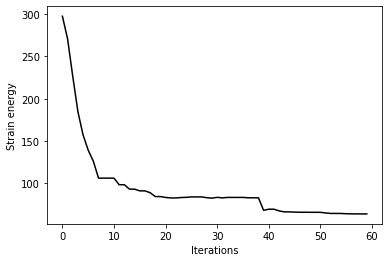

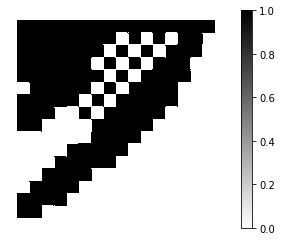

In [7]:
from skfem.visuals.matplotlib import plot
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# Number of elements
N = basis.nelems
# Initial guess is a homogeneous distribution 
rho0 = vol_constraint * np.ones(N)
# The design variables are limited to the range 0 to 1
bounds = N*[(0.0, 1.0)]
# The inequality constraint limits the maximum volume occupied by filled material
constraints = {'type':'ineq', 'fun': lambda x : vol_constraint*N-np.sum(x)}
hess = lambda x: np.zeros((N, N))
# Increase the maximum allowed iterations for the solver
options = {"maxiter": 100}
# Save functions values during optimization for plotting
energies = []
def callback(x, state):
    energies.append(state.fun)

# Run the actual optimization
res = minimize(target_function, rho0, method="trust-constr", constraints=constraints, bounds=bounds, options=options, hess=hess, callback=callback)
print(f"Success state:{res.success}")
print(f"Iterations: {res.nit}")
print(f"Solver message: {res.message}")

# Plot the optimization convergence
plt.plot(energies, "-k")
plt.xlabel("Iterations")
plt.ylabel("Strain energy")

# plot the resulting material distribution
plot(mesh, res.x, cmap=plt.cm.binary, colorbar=True, vmin=0, vmax=1.0)